In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm



import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.table

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Custom functions

In [2]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)


In [3]:
# at the moment comcam only in Cassandra
# from lsst.analysis.ap import apdbCassandra
# or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')
# comcam_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcam.py')

# Import data

In [8]:
# Load collection
repo = "embargo_new"
collection = "LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988"
instrument = "LSSTComCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

In [9]:
bands = ["u", "g", "r", "i", "z", "y"]

verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 1074 differenceExps for band 'u'
Found 2223 differenceExps for band 'g'
Found 4049 differenceExps for band 'r'
Found 2411 differenceExps for band 'i'
Found 765 differenceExps for band 'z'
Found 584 differenceExps for band 'y'


In [10]:
i = 50
data_id = datasetRefs_dia[i].dataId
print(data_id)

{instrument: 'LSSTComCam', detector: 0, visit: 2024112000314, band: 'y', day_obs: 20241120, physical_filter: 'y_04'}


In [11]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
src_refs = butler.query_datasets("sourceTable_visit")
print(len(lc_refs))
print(len(obj_refs))
print(len(src_refs))

45
45
1259


In [12]:
diaSrc_refs = butler.query_datasets("goodSeeingDiff_diaSrc")

print(len(diaSrc_refs))

11106


Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

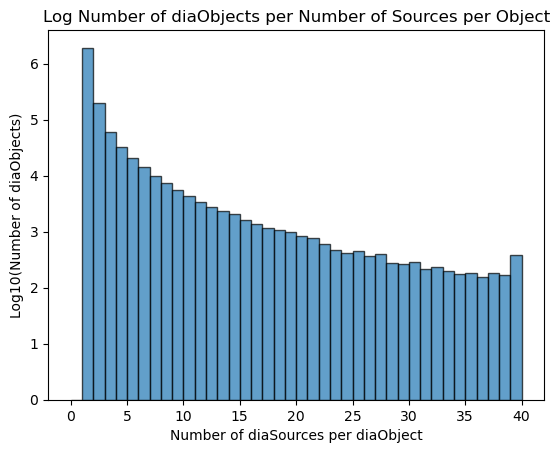

In [13]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tqdm(tract_indices):
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    dia_Obj = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(dia_Obj)
    diaSource_list.append(diaSource)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

dia_Obj = combined_dia_Obj.copy()
diaSource = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

In [11]:
# List of tract indices to process
visit_indices = np.arange(0, 100)

# 

Source_list = []

# Loop through the specified tracts and fetch the data
for idx in tqdm(visit_indices):
    src_ref = src_refs[idx]  # Select the corresponding obj_ref
    Source = butler.get('sourceTable_visit', dataId=src_ref.dataId)  # Fetch Source for this tract
    
    Source_list.append(Source)


combined_Source = pd.concat(Source_list, ignore_index=False)

  0%|                                                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.91it/s]


# Number of diaObjects per magnitude

In [14]:
output_string = (
    f"Number of unique visits: {len(np.unique(diaSource['visit']))}, "
    f"Number of unique diaObjectId: {len(np.unique(diaSource['diaObjectId']))}, "
    f"Total number of diaSource entries: {len(diaSource)}"
)

print(output_string)

Number of unique visits: 1256, Number of unique diaObjectId: 2314013, Total number of diaSource entries: 3856270


In [13]:
"""
dia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)
template = butler.get("goodSeeingDiff_templateExp", dataId=data_id)
calexp = butler.get("calexp", dataId=data_id)
src = butler.get("src", dataId=data_id)
dia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)
dia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) 
"""

'\ndia = butler.get("goodSeeingDiff_differenceExp", dataId=data_id)\ntemplate = butler.get("goodSeeingDiff_templateExp", dataId=data_id)\ncalexp = butler.get("calexp", dataId=data_id)\nsrc = butler.get("src", dataId=data_id)\ndia_src = butler.get("goodSeeingDiff_diaSrc", dataId=data_id)\ndia_src_table = butler.get("goodSeeingDiff_diaSrcTable", dataId=data_id) \n'

In [16]:
# Step 1: Calculate mean flux and mean SNR for each diaObjectId in each band
mean_flux_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['scienceFlux'].mean().unstack(fill_value=0)
mean_snr_per_object_band = diaSource.groupby(['diaObjectId', 'band'])['snr'].mean().unstack(fill_value=-99)

# Rename columns dynamically for all bands
band_flux_columns = {band: f"{band}_band_flux_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
band_snr_columns = {band: f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']}
mean_flux_per_object_band = mean_flux_per_object_band.rename(columns=band_flux_columns).reset_index()
mean_snr_per_object_band = mean_snr_per_object_band.rename(columns=band_snr_columns).reset_index()

# Step 2: Merge mean flux and SNR values into dia_Obj_field
dia_Obj_field_updated = dia_Obj.merge(mean_flux_per_object_band, on='diaObjectId', how='left')
dia_Obj_field_updated = dia_Obj_field_updated.merge(mean_snr_per_object_band, on='diaObjectId', how='left')

# Step 3: Calculate magnitudes for all bands
for band in tqdm(['i', 'g', 'r', 'y', 'z', 'u']):
    flux_col = f"{band}_band_flux_mean"
    mag_col = f"{band}_band_mag"
    dia_Obj_field_updated[mag_col] = create_mag(dia_Obj_field_updated[flux_col].values)

# Replace infinite values with NaN
dia_Obj_field_updated.replace([np.inf, -99, -np.inf], np.nan, inplace=True)

# Select and display the magnitude columns, SNR, and diaObjectId
output_columns = ['diaObjectId'] + \
                 [f"{band}_band_mag" for band in ['i', 'g', 'r', 'y', 'z', 'u']] + \
                 [f"{band}_band_snr_mean" for band in ['i', 'g', 'r', 'y', 'z', 'u']]

result = dia_Obj_field_updated[output_columns]

# Display the resulting DataFrame
result 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.76it/s]


,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,2333928934233604097,NaN,NaN,NaN,NaN,NaN,16.625045,NaN,NaN,NaN,NaN,NaN,25.654030
1,2333928934233604098,NaN,NaN,NaN,NaN,NaN,17.584630,NaN,NaN,NaN,NaN,NaN,46.471748
2,2333933332280115201,NaN,NaN,NaN,15.985738,NaN,NaN,NaN,NaN,NaN,18.742929,NaN,NaN
3,2333933332280115202,NaN,NaN,17.350393,NaN,NaN,NaN,NaN,NaN,5.792743,NaN,NaN,NaN
4,2333933332280115203,19.574513,NaN,NaN,NaN,NaN,NaN,14.416055,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314008,2508865632259276802,NaN,NaN,17.744209,NaN,NaN,NaN,NaN,NaN,9.261279,NaN,NaN,NaN
2314009,2508865632259276803,NaN,NaN,18.836163,NaN,NaN,NaN,NaN,NaN,5.101959,NaN,NaN,NaN
2314010,2508870030305787905,NaN,NaN,18.326836,NaN,NaN,NaN,NaN,NaN,5.429317,NaN,NaN,NaN
2314011,2508870030305787906,NaN,NaN,18.348337,NaN,NaN,NaN,NaN,NaN,5.305370,NaN,NaN,NaN


In [17]:
result

,diaObjectId,i_band_mag,g_band_mag,r_band_mag,y_band_mag,z_band_mag,u_band_mag,i_band_snr_mean,g_band_snr_mean,r_band_snr_mean,y_band_snr_mean,z_band_snr_mean,u_band_snr_mean
0,2333928934233604097,NaN,NaN,NaN,NaN,NaN,16.625045,NaN,NaN,NaN,NaN,NaN,25.654030
1,2333928934233604098,NaN,NaN,NaN,NaN,NaN,17.584630,NaN,NaN,NaN,NaN,NaN,46.471748
2,2333933332280115201,NaN,NaN,NaN,15.985738,NaN,NaN,NaN,NaN,NaN,18.742929,NaN,NaN
3,2333933332280115202,NaN,NaN,17.350393,NaN,NaN,NaN,NaN,NaN,5.792743,NaN,NaN,NaN
4,2333933332280115203,19.574513,NaN,NaN,NaN,NaN,NaN,14.416055,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314008,2508865632259276802,NaN,NaN,17.744209,NaN,NaN,NaN,NaN,NaN,9.261279,NaN,NaN,NaN
2314009,2508865632259276803,NaN,NaN,18.836163,NaN,NaN,NaN,NaN,NaN,5.101959,NaN,NaN,NaN
2314010,2508870030305787905,NaN,NaN,18.326836,NaN,NaN,NaN,NaN,NaN,5.429317,NaN,NaN,NaN
2314011,2508870030305787906,NaN,NaN,18.348337,NaN,NaN,NaN,NaN,NaN,5.305370,NaN,NaN,NaN


In [18]:
result.to_parquet('result.parquet', index=False)

print("DataFrame saved as 'result.parquet'.")

DataFrame saved as 'result.parquet'.


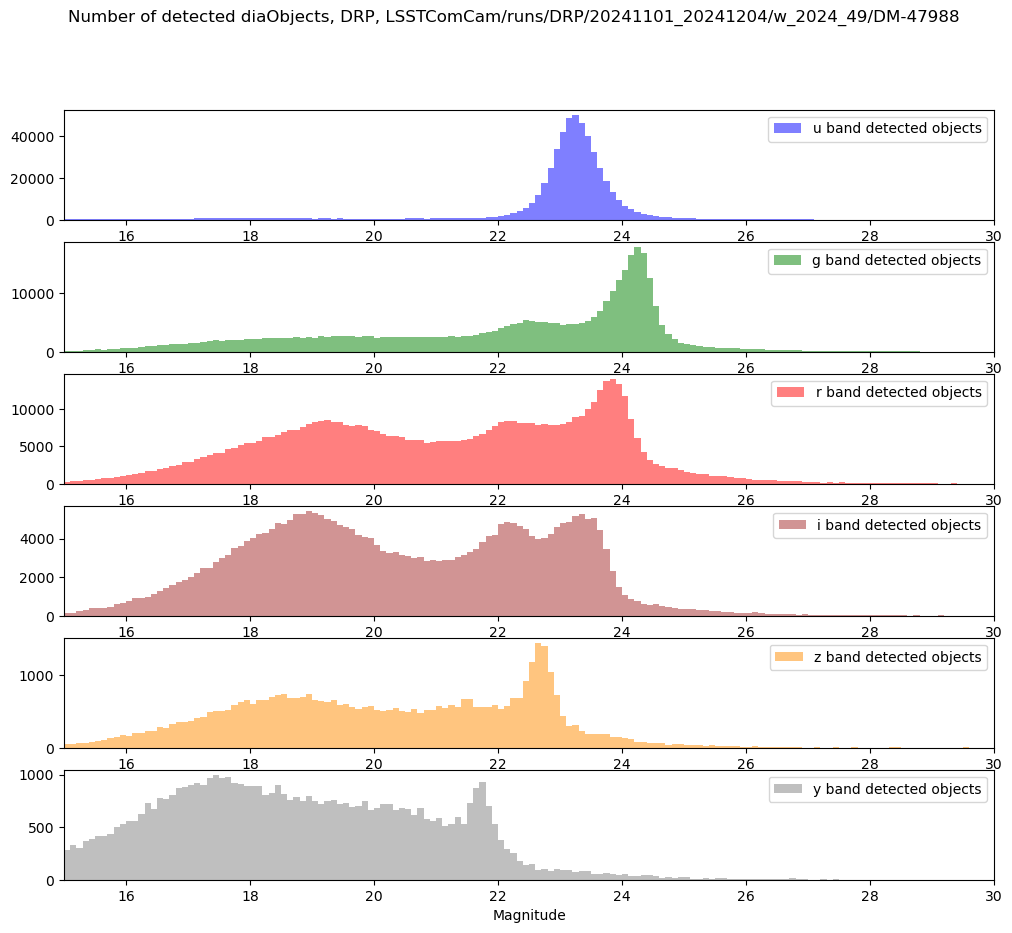

In [25]:
plt.figure(figsize=(12, 10))
plt.suptitle('Number of detected diaObjects, DRP, LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988')

plt.subplot(6, 1, 1)
plt.hist(result['u_band_mag'][~np.isnan(result['u_band_mag'])], color='blue', alpha=0.5, bins=np.arange(15,30,0.1), label='u band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 2)
plt.hist(result['g_band_mag'][~np.isnan(result['g_band_mag'])], color='g', alpha=0.5, bins=np.arange(15,30,0.1), label='g band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1, 3)
plt.hist(result['r_band_mag'][~np.isnan(result['r_band_mag'])], color='r', alpha=0.5, bins=np.arange(15,30,0.1), label='r band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,4)
plt.hist(result['i_band_mag'][~np.isnan(result['i_band_mag'])], color='brown', alpha=0.5, bins=np.arange(15,30,0.1), label='i band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,5)
plt.hist(result['z_band_mag'][~np.isnan(result['z_band_mag'])], color='darkorange', alpha=0.5, bins=np.arange(15,30,0.1), label='z band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

plt.subplot(6, 1,6)
plt.hist(result['y_band_mag'][~np.isnan(result['y_band_mag'])], color='gray', alpha=0.5, bins=np.arange(15,30,0.1), label='y band detected objects');
plt.xlim(15, 30)
plt.xlabel('Magnitude')
plt.legend();

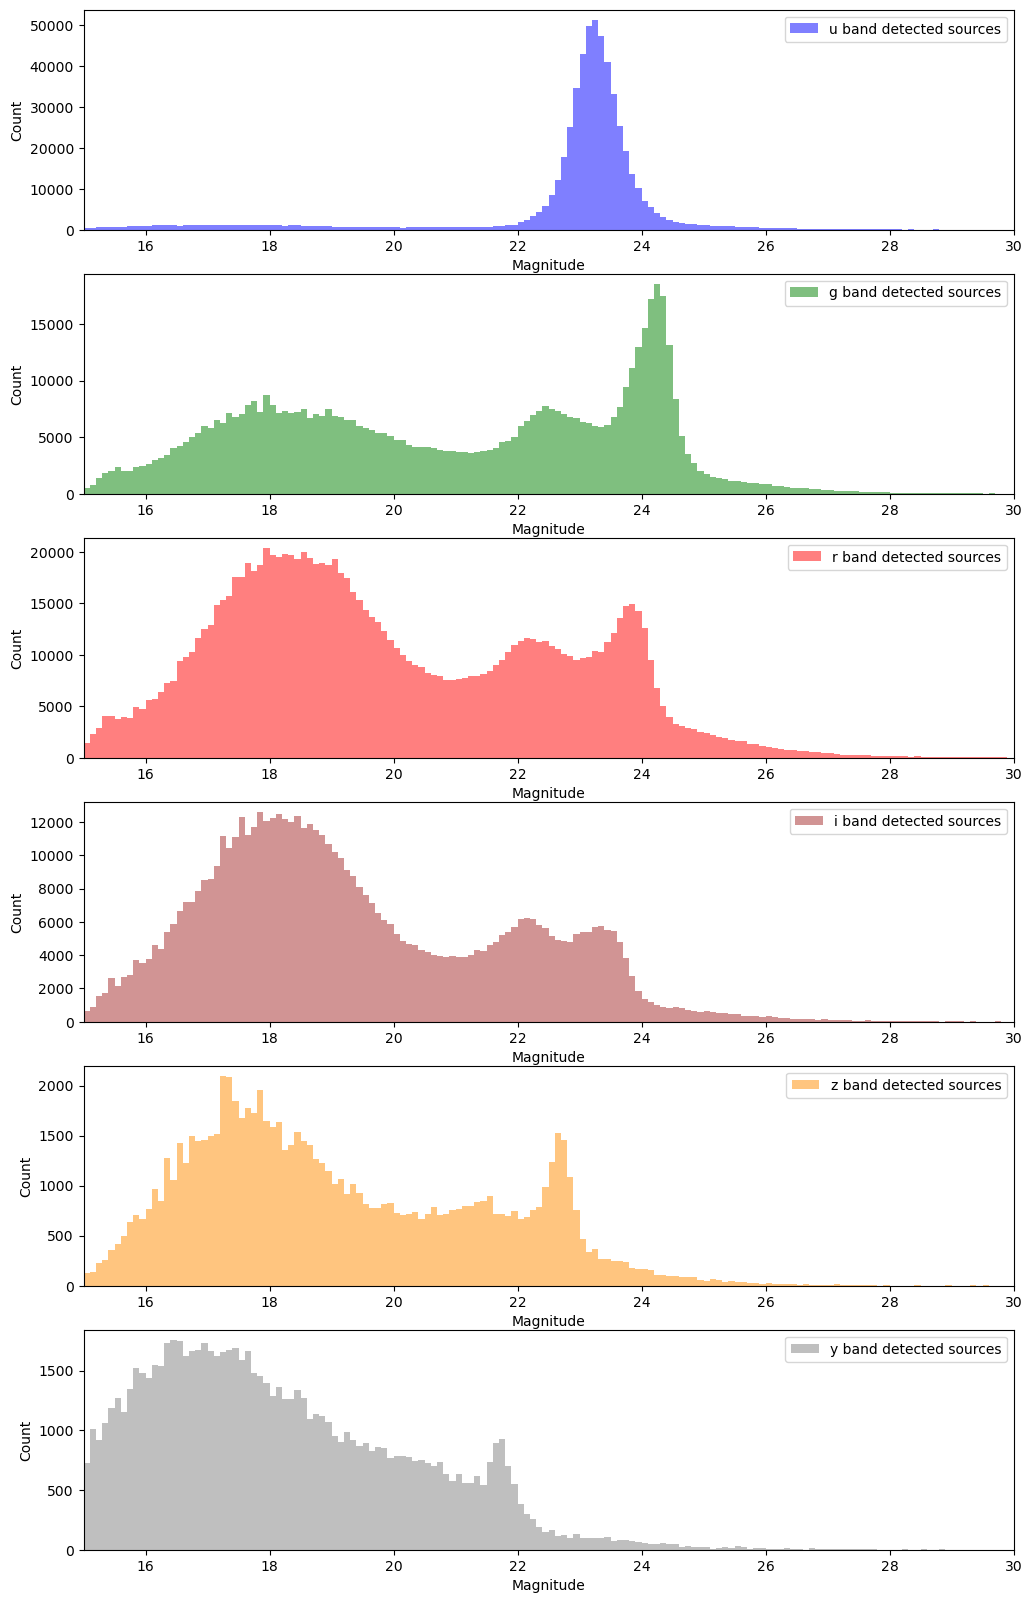

In [38]:

bands = ['u', 'g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'brown', 'darkorange', 'grey']

plt.figure(figsize=(12, 20))  # Set the figure size

for i, band in enumerate(bands):
    plt.subplot(6, 1, i + 1)  # Create subplot for each band
    diaSource_band = diaSource[diaSource['band'] == band]
    
    # Plot histogram of magnitudes, ignoring NaN values
    plt.hist(
        diaSource_band['mag'][~np.isnan(diaSource_band['mag'])], 
        color=colors[i], alpha=0.5, 
        bins=np.arange(15, 30, 0.1), 
        label=f'{band} band detected sources'
    )
    
    plt.xlim(15, 30)  # Set x-axis limits
    plt.xlabel('Magnitude')
    plt.ylabel('Count')
    plt.legend()

plt.show()


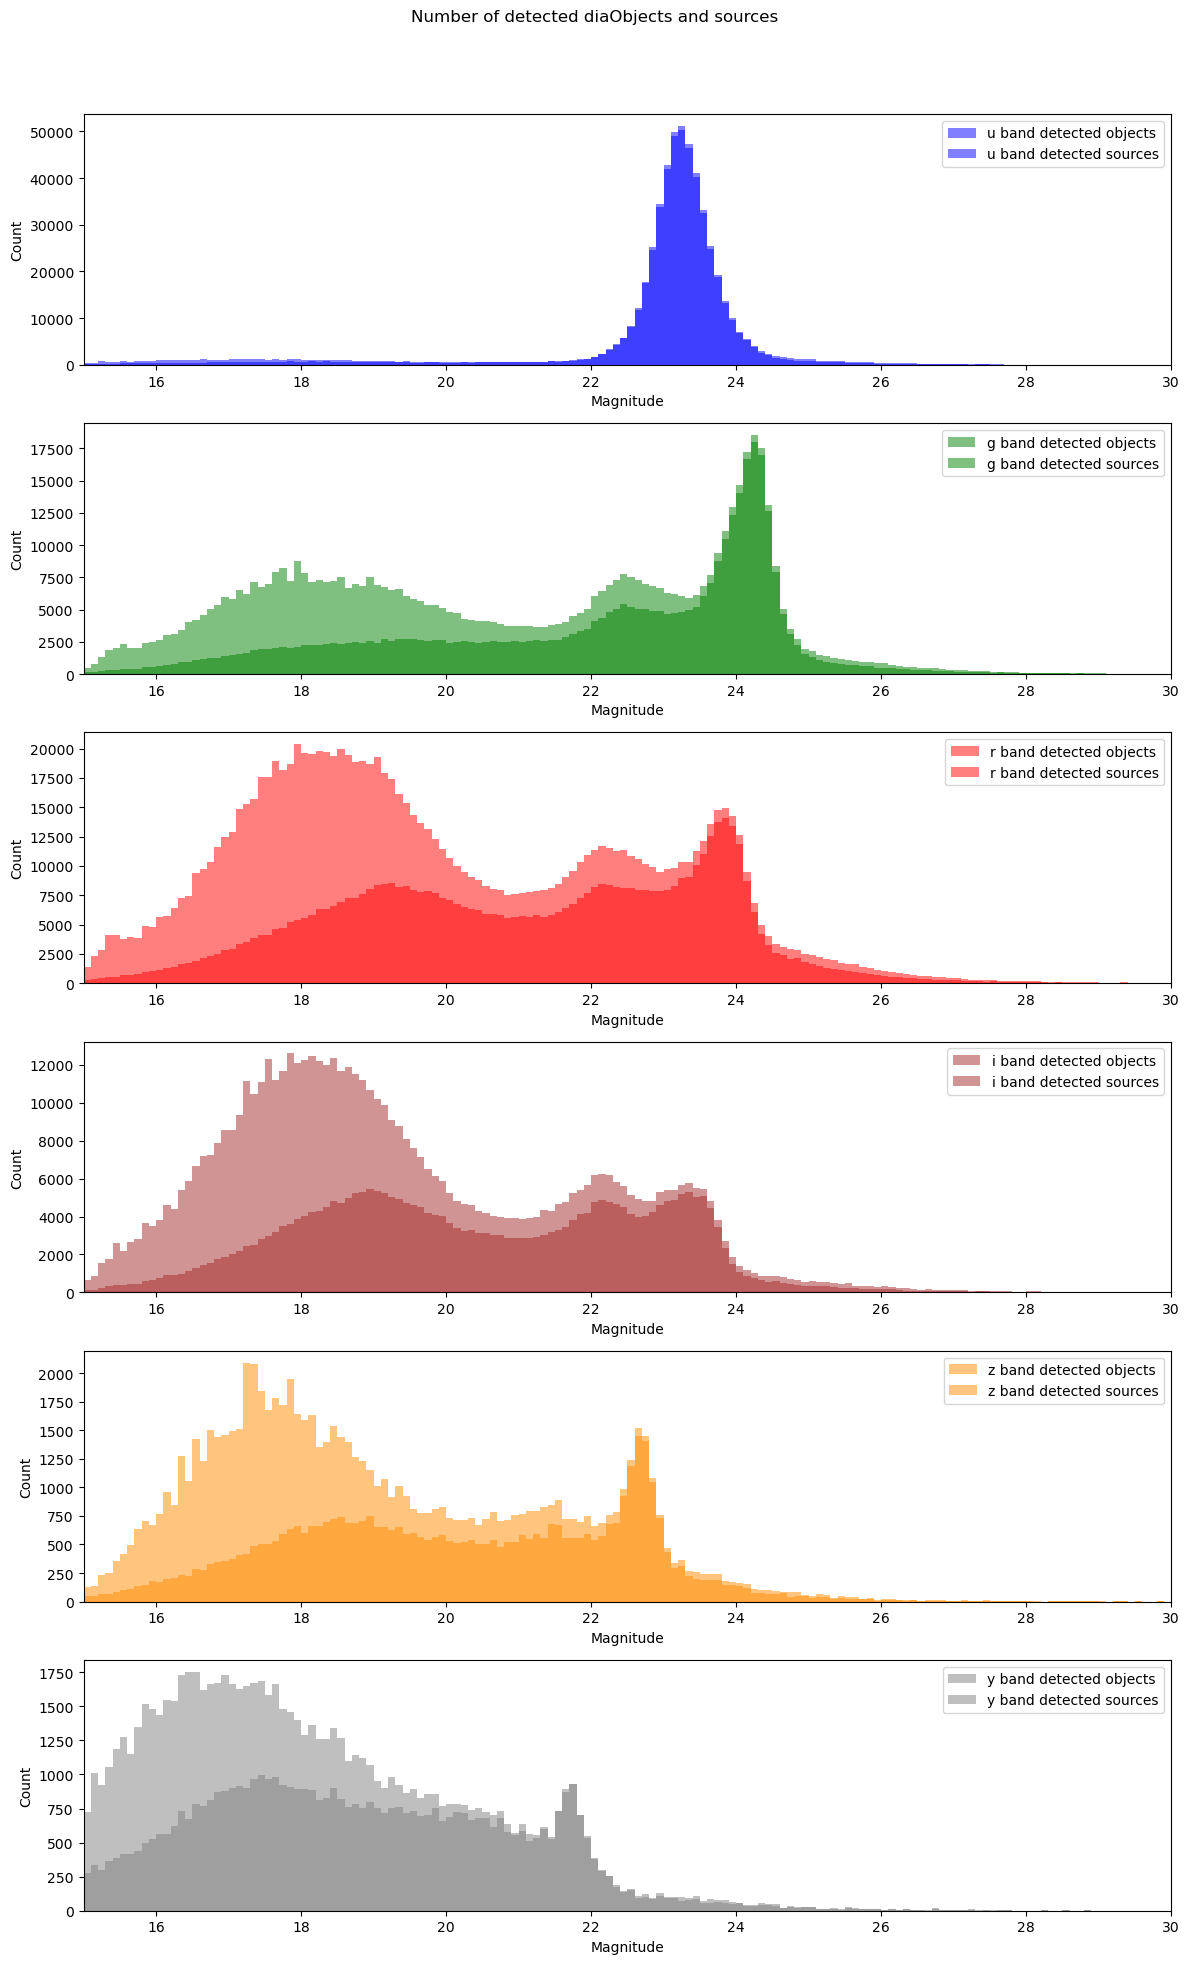

In [39]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
colors1 = ['blue', 'green', 'red', 'brown', 'darkorange', 'gray']  # Colors for the first dataset
colors2 = colors1  # Colors for the second dataset

plt.figure(figsize=(12, 20))
plt.suptitle('Number of detected diaObjects and sources')

for i, band in enumerate(bands):
    plt.subplot(6, 1, i + 1)  # Create subplot for each band
    
    # First histogram: "result" data
    plt.hist(
        result[f'{band}_band_mag'][~np.isnan(result[f'{band}_band_mag'])],
        color=colors1[i], alpha=0.5, bins=np.arange(15, 30, 0.1),
        label=f'{band} band detected objects'
    )
    
    # Second histogram: "diaSource" data
    diaSource_band = diaSource[diaSource['band'] == band]
    plt.hist(
        diaSource_band['mag'][~np.isnan(diaSource_band['mag'])],
        color=colors2[i], alpha=0.5, bins=np.arange(15, 30, 0.1),
        label=f'{band} band detected sources'
    )
    
    plt.xlim(15, 30)  # Set x-axis limits
    plt.xlabel('Magnitude')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout, leaving space for the title
plt.show()

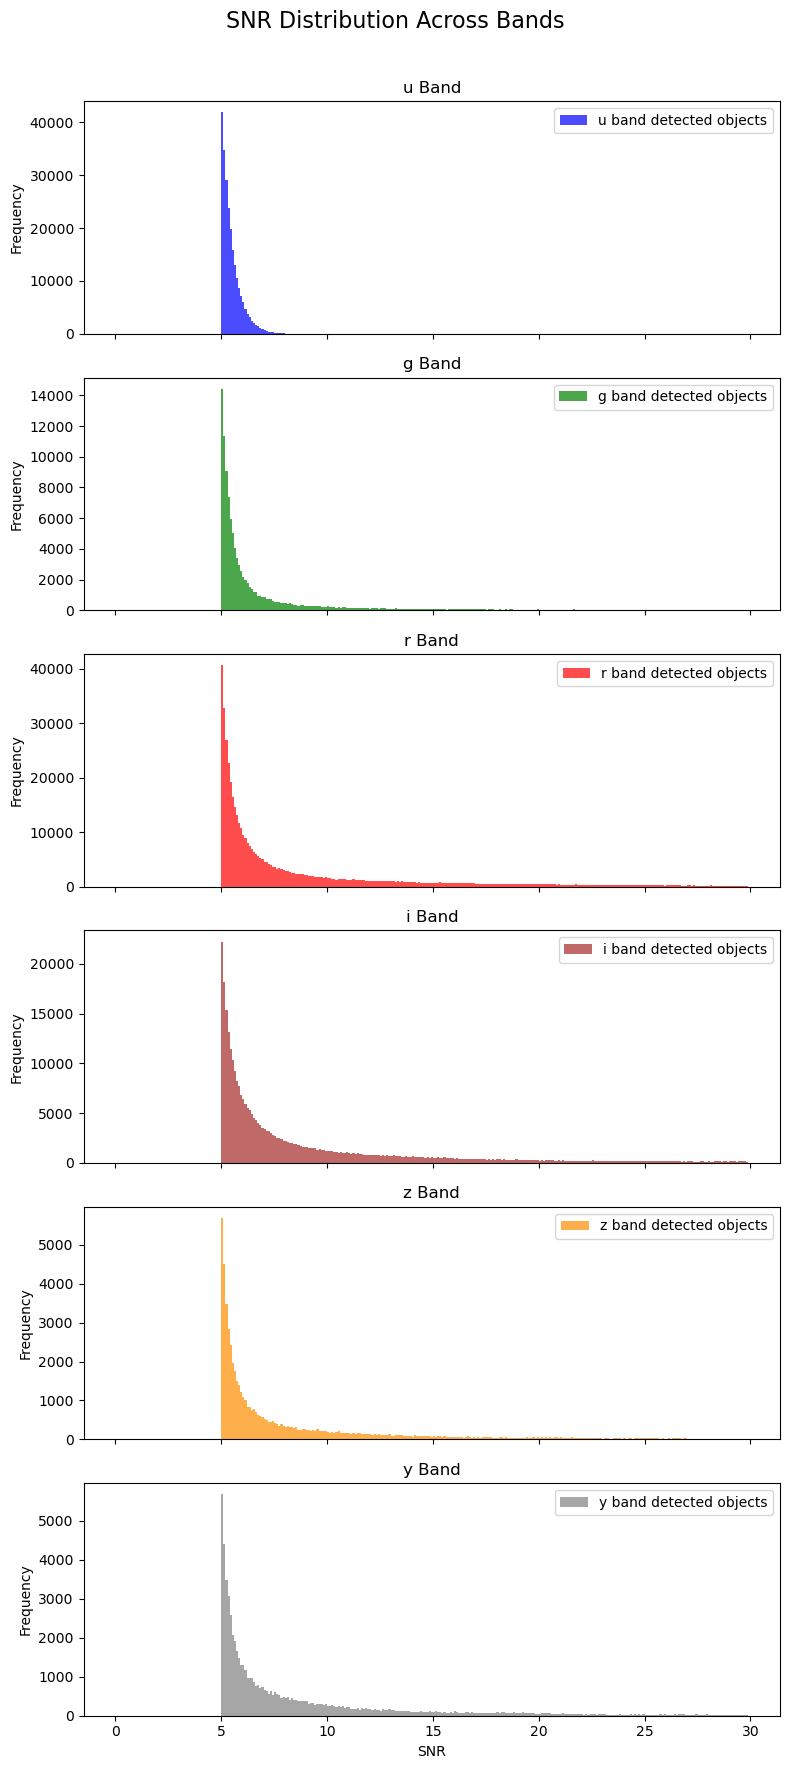

In [ ]:

# Define colors for each band
band_colors = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'brown',
    'z': 'darkorange',
    'y': 'gray'
}

# Define the bands
bands = ['u', 'g', 'r', 'i', 'z', 'y']

# Create subplots with one figure per band
fig, axes = plt.subplots(len(bands), 1, figsize=(8, 18), sharex=True)
fig.suptitle('SNR Distribution Across Bands', fontsize=16)

for ax, band in zip(axes, bands):
    # Dynamically get the correct SNR column for the current band
    column_name = f'{band}_band_snr_mean'
    snr_values = result[column_name][~np.isnan(result[column_name])]
    
    # Plot the histogram for the current band
    ax.hist(
        snr_values, 
        color=band_colors[band], 
        alpha=0.7, 
        bins=np.arange(0, 30, 0.1), 
        label=f'{band} band detected objects'
    )
    ax.set_ylabel('Frequency')
    ax.set_title(f'{band} Band')
    ax.legend()

# Set common x-axis label
axes[-1].set_xlabel('SNR')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle
plt.show()

In [ ]:
diaSource.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'extendedness',
       'reliability', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 

# Positive and negative sources

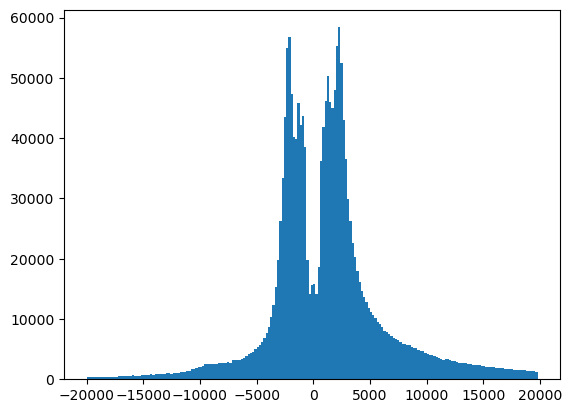

In [ ]:
# Let us look at the flux distribution of the sources and see if it is reasonably symmetric
plt.hist(diaSource['psfFlux'],bins=np.arange(-20000,20000,200));

In [ ]:
np.sum(diaSource[diaSource['psfFlux']<0]['shape_flag'])/len(diaSource[diaSource['psfFlux']<0]['shape_flag'])

0.8325305632093318

In [ ]:
single_obj = dia_Obj[dia_Obj['nDiaSources'] > 10].iloc[230]
single_obj

ra                         58.634976
dec                       -49.108668
nDiaSources                16.000000
radecMjdTai             60641.110204
g_psfFluxLinearSlope             NaN
                            ...     
u_psfFluxSigma                   NaN
u_scienceFluxSigma               NaN
u_psfFluxSkew                    NaN
u_psfFluxChi2                    NaN
u_psfFluxStetsonJ                NaN
Name: 1052923121083875358, Length: 136, dtype: float64

# MVW plot (i.e., shapes)

In [20]:
# Select a specific band, e.g., 'i'
selected_band = 'g'
src_subselection = diaSource.copy()

# Add 'diaSourceId' as a column
src_subselection['diaSourceId'] = src_subselection.index

# Filter for the selected band
# src_subselection = src_subselection[src_subselection['band'] == selected_band]

# Subset the relevant columns
src_subselection = src_subselection[['diaSourceId', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag']]


Text(0.5, 1.0, 'Shape Histogram of diaSources, all 6 bands, ComCam')

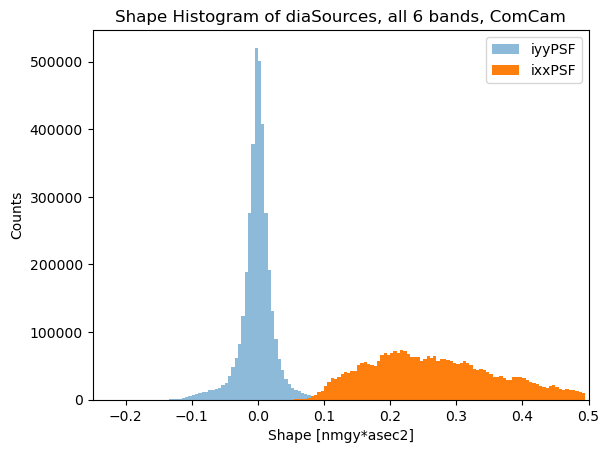

In [24]:
plt.hist(src_subselection['iyyPSF'],  bins=np.arange(-0.25,0.5,0.005), label='iyyPSF', alpha = 0.5);
plt.hist(src_subselection['ixxPSF'],  bins=np.arange(-0.25,0.5,0.005), label='ixxPSF');
# plt.hist(src_subselection['ixyPSF'],  bins=np.arange(-0.25,0.5,0.005), label='ixyPSF', alpha = 0.5);

# plt.hist(src_subselection['iyy'],  bins=np.arange(-0.25,0.5,0.005), label='iyy',alpha=0.5);
# plt.hist(src_subselection['ixx'],  bins=np.arange(-0.25,0.5,0.005), label='ixx', alpha=0.5);

plt.xlim(-0.25, 0.5)
plt.legend()
plt.xlabel('Shape [nmgy*asec2]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, all 6 bands, ComCam')

Text(0, 0.5, 'Counts')

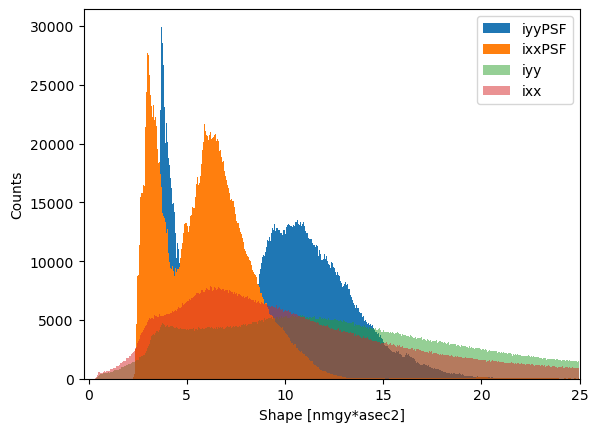

In [ ]:
plt.hist(combined_Source['iyyPSF'],  bins=np.arange(-0.25,25,0.05), label='iyyPSF');
plt.hist(combined_Source['ixxPSF'],  bins=np.arange(-0.25,25,0.05), label='ixxPSF');

plt.hist(combined_Source['iyy'],  bins=np.arange(-0.25,25,0.05), label='iyy',alpha=0.5);
plt.hist(combined_Source['ixx'],  bins=np.arange(-0.25,25,0.05), label='ixx', alpha=0.5);

plt.xlim(-0.25, 25)
plt.legend()
plt.xlabel('Shape ')
plt.ylabel('Counts')

In [ ]:
# same for the source catalog and their 

In [ ]:
combined_Source['iyy']

sourceId
190769886656462849    74.561886
190769886656462850    28.839572
190769886656462851    85.606775
190769886656462852     8.432170
190769886656462853    20.860990
                        ...    
190875507452022055    12.363163
190875507452022056          NaN
190875507452022057          NaN
190875507452022058          NaN
190875507452022059          NaN
Name: iyy, Length: 2175863, dtype: float64

In [ ]:
# do the same on src catalog, not diaSRc

In [ ]:
diaSrc_refs[0]

In [ ]:
sources=[]
for i in tqdm(range(400)):
    diaSrc = butler.get('goodSeeingDiff_diaSrc', dataId=diaSrc_refs[i].dataId)
    sources.append(diaSrc.asAstropy())
    
sources = astropy.table.vstack(sources)
     

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.46it/s]


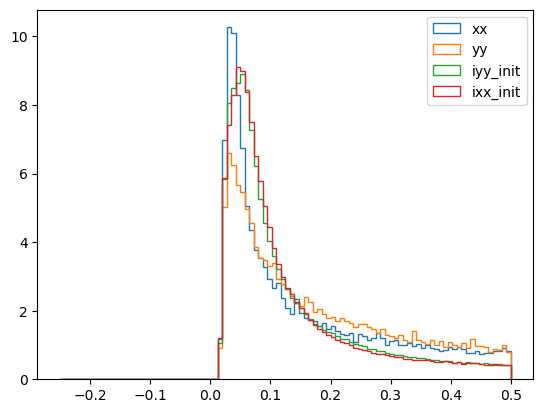

In [ ]:
setting = {'histtype': 'step', 'bins': 100, 'range':(-0.25,0.5),  'density': True}
plt.hist(sources['slot_Shape_xx']/25, **setting, label='xx');
plt.hist(sources['slot_Shape_yy']/25, **setting, label='yy');

plt.hist(src_subselection['iyy'], **setting, label='iyy_init');
plt.hist(src_subselection['ixx'],  **setting, label='ixx_init');

# plt.hist(diaSrc['slot_Shape_xy'], **setting, label='xy');
plt.legend()


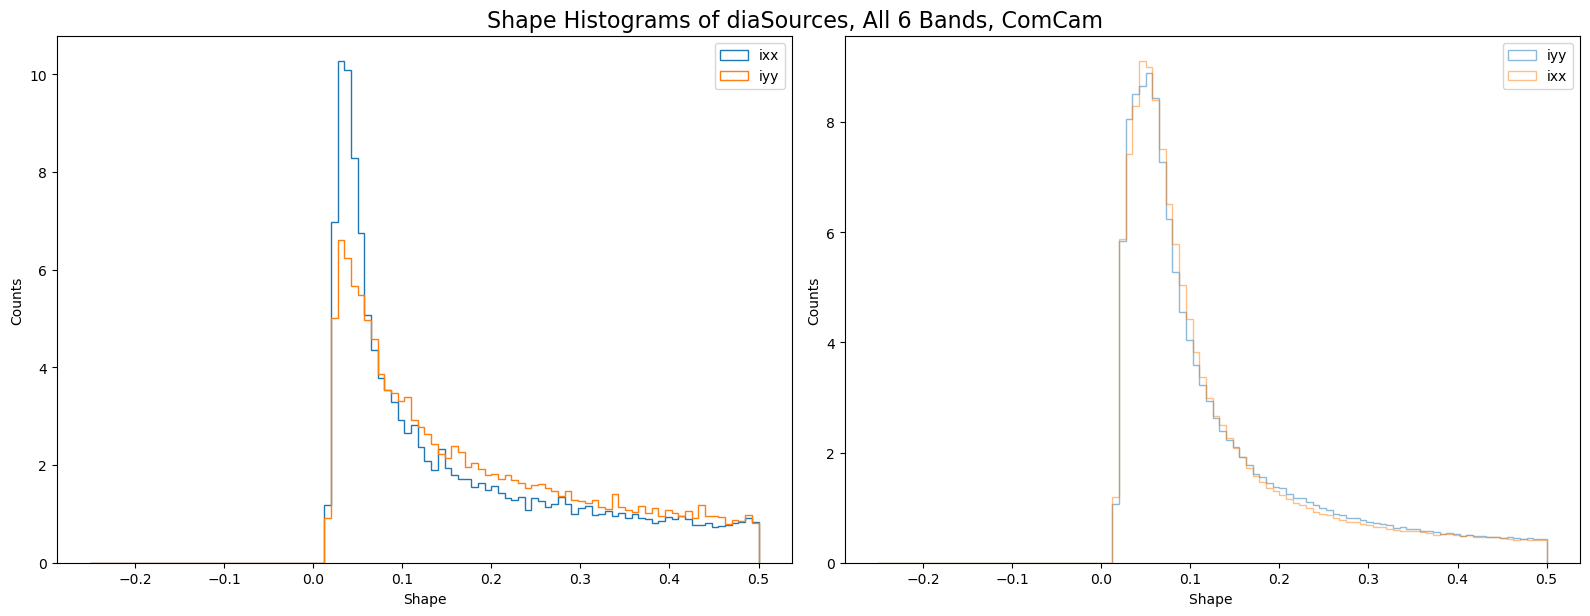

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# First subplot: Wide range
axes[0].hist(sources['slot_Shape_xx']/25, **setting, label='ixx')
axes[0].hist(sources['slot_Shape_yy']/25, **setting, label='iyy')
axes[0].legend()
axes[0].set_xlabel('Shape')
axes[0].set_ylabel('Counts')


# Second subplot: Narrow range
#axes[1].hist(src_subselection['iyyPSF'], bins=np.arange(-0.25, 0.5, 0.005), label='iyyPSF')
#axes[1].hist(src_subselection['ixxPSF'], bins=np.arange(-0.25, 0.5, 0.005), label='ixxPSF')
axes[1].hist(src_subselection['iyy'], **setting, label='iyy', alpha=0.5)
axes[1].hist(src_subselection['ixx'], **setting, label='ixx', alpha=0.5)
axes[1].legend()
axes[1].set_xlabel('Shape ')
axes[1].set_ylabel('Counts')


# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle('Shape Histograms of diaSources, All 6 Bands, ComCam', fontsize=16, y=1.02)

# Show the combined plot
plt.show()

In [ ]:
per pixels square per arcsec squared

# per pixel?
# 1. ap per arcsec2, drp per pixel2
# plot do not line up

In [ ]:
(3600 * np.degrees(np.sqrt(np.fabs(cd))))**2

array([0.04018657, 0.04015589, 0.04015386, 0.04015806, 0.04019631,
       0.04017221, 0.04018233, 0.04015783, 0.04015728, 0.04015675,
       0.04016157, 0.04015802, 0.04015803, 0.04015728, 0.04015697,
       0.04019726, 0.04019515, 0.04015636, 0.04019506, 0.04019367,
       0.0401767 , 0.04014995, 0.04019173, 0.04017586, 0.04019491,
       0.04018681, 0.04017533, 0.04016067, 0.04016419, 0.04017524,
       0.04015882, 0.04019532, 0.04018472, 0.0401725 , 0.0401474 ,
       0.04015454, 0.04018371, 0.04015106, 0.04017936, 0.0401757 ,
       0.04016835, 0.04017639, 0.04017334, 0.0401744 , 0.0401401 ,
       0.04017622, 0.04016598, 0.04017401, 0.04014058, 0.04017137,
       0.04013914, 0.04018057, 0.0401401 , 0.04013943, 0.04013893,
       0.0401855 , 0.04018554, 0.04017508, 0.04018457, 0.04017096,
       0.04017391, 0.04016578, 0.04017293, 0.04018483, 0.04016935,
       0.04017675, 0.04016889, 0.04015645, 0.0401744 , 0.04017071,
       0.04016989, 0.04017681, 0.04017323, 0.04015931, 0.04017

In [ ]:
cd = diaSrc['base_LocalWcs_CDMatrix_1_1'] * diaSrc['base_LocalWcs_CDMatrix_2_2'] - diaSrc['base_LocalWcs_CDMatrix_1_2'] * diaSrc['base_LocalWcs_CDMatrix_2_1']

In [ ]:
diaSrc['base_LocalWcs_CDMatrix_1_1']

array([1.74142277e-07, 1.73400666e-07, 1.73352406e-07, 1.73400161e-07,
       1.74317926e-07, 1.73728113e-07, 1.73959570e-07, 1.73366477e-07,
       1.73334455e-07, 1.73298617e-07, 1.73408353e-07, 1.73345425e-07,
       1.73326232e-07, 1.73298640e-07, 1.73291504e-07, 1.74224344e-07,
       1.74045685e-07, 1.73109448e-07, 1.74033874e-07, 1.73997836e-07,
       1.73588732e-07, 1.72936249e-07, 1.73893777e-07, 1.73510477e-07,
       1.73963257e-07, 1.73766051e-07, 1.73490988e-07, 1.73054305e-07,
       1.73054127e-07, 1.73309083e-07, 1.72901544e-07, 1.73723621e-07,
       1.73429961e-07, 1.73132557e-07, 1.72532607e-07, 1.72618565e-07,
       1.73299981e-07, 1.72446066e-07, 1.73089589e-07, 1.72991317e-07,
       1.72791640e-07, 1.72929527e-07, 1.72845081e-07, 1.72765376e-07,
       1.72010906e-07, 1.72859395e-07, 1.72596808e-07, 1.72780989e-07,
       1.71998012e-07, 1.72704528e-07, 1.71939549e-07, 1.72921652e-07,
       1.71958759e-07, 1.71928953e-07, 1.71908125e-07, 1.73001886e-07,
      

In [ ]:
pipetask run -b embargo -i LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841 -o u/yusra/DM-47386 -p $DRP_PIPE_DIR/pipelines/LSSTComCam/DRP.yaml#subtractImages,detectAndMeasureDiaSources,transformDiaSourceCat -d "visit > 2024112600103 AND visit < 2024112600116 AND instrument='LSSTComCam'" -j 9

u/yusra/DM-47386

In [55]:
# Load collection
repo = "embargo_new"
collection = "u/yusra/DM-47386"
instrument = "LSSTComCam"

butler = dafButler.Butler(repo, collections=collection, instrument=instrument)

# List of visits
visits = [
     2024112600104, 2024112600105, 2024112600106,
    2024112600107, 2024112600108, 2024112600109, 2024112600110,
    2024112600111, 2024112600112, 2024112600113, 2024112600114,
    2024112600115
]

# Initialize an empty list to collect DataFrames
diaSource_list = []

# Loop over visits and detectors
for visit in visits:
    for detector in range(0, 9):
        try:
            # Fetch the diaSource table for the current visit and detector
            diaSource = butler.get(
                'goodSeeingDiff_diaSrcTable',
                dataId={'visit': visit, 'instrument': 'LSSTComCam', 'detector': detector}
            )
            # Convert the result to a Pandas DataFrame (if not already a DataFrame)
            diaSource_df = pd.DataFrame(diaSource)

            # Add columns to track visit and detector
            diaSource_df['visit'] = visit
            diaSource_df['detector'] = detector

            # Append to the list
            diaSource_list.append(diaSource_df)
        except Exception as e:
            # Handle errors gracefully
            print(f"Failed to fetch data for visit {visit}, detector {detector}: {e}")

# Combine all DataFrames into one
all_diaSource_df = pd.concat(diaSource_list, ignore_index=False)


Text(0, 0.5, 'Counts')

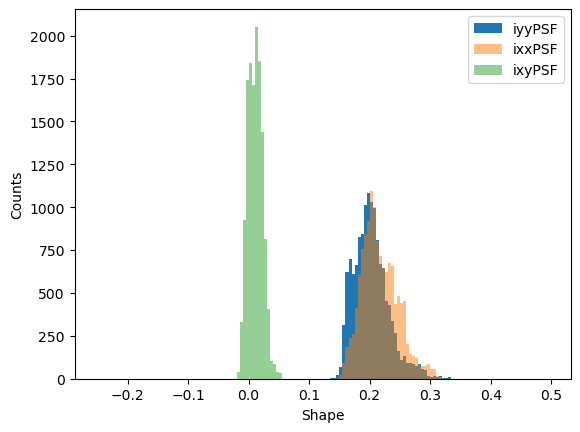

In [57]:
plt.hist(all_diaSource_df['iyyPSF'],  bins=np.arange(-0.25,0.5,0.005), label='iyyPSF', alpha = 1);
plt.hist(all_diaSource_df['ixxPSF'],  bins=np.arange(-0.25,0.5,0.005), label='ixxPSF', alpha = 0.5);
plt.hist(all_diaSource_df['ixyPSF'],  bins=np.arange(-0.25,0.5,0.005), label='ixyPSF', alpha = 0.5);
plt.legend()
plt.xlabel('Shape')
plt.ylabel('Counts')

In [68]:
all_diaSource_df[['snr','psfFlux','psfFluxErr', 'isDipole']]

,snr,psfFlux,psfFluxErr,isDipole
0,6.217139,-1388.344359,234.649907,False
1,11.619290,-62.989840,356.443961,True
2,26.143602,22890.348939,837.171064,False
3,5.866943,2051.500982,351.701229,True
4,9.250191,3024.581151,321.131935,True
...,...,...,...,...
61,5.419498,1000.733742,173.325040,False
62,10.932996,2070.936100,173.528622,False
63,8.240829,1450.217519,168.262884,False
64,5.386925,1576.831876,283.277445,False


In [106]:
all_diaSource_df_not_dipole=all_diaSource_df[all_diaSource_df['isDipole']==False]
psf_flux_ratio = all_diaSource_df_not_dipole['psfFlux']/all_diaSource_df_not_dipole['psfFluxErr']

(0.0, 100.0)

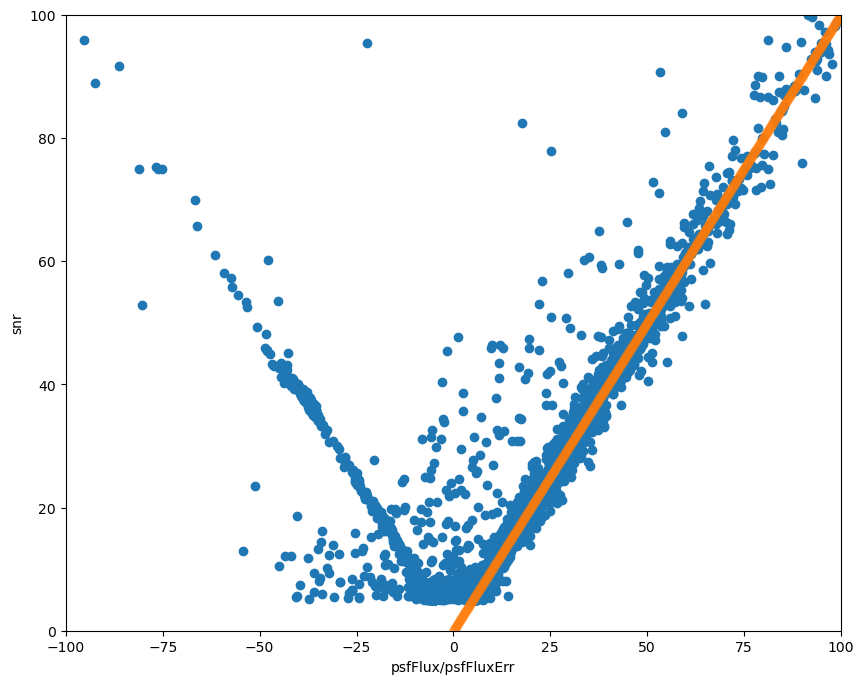

In [108]:
plt.figure(figsize=(10, 8))
plt.scatter(all_diaSource_df_not_dipole['psfFlux']/all_diaSource_df_not_dipole['psfFluxErr'] , all_diaSource_df_not_dipole['snr'], alpha=1);
plt.scatter(np.arange(0,2000,0.1), np.arange(0,2000,0.1), alpha=0.2)

plt.xlabel('psfFlux/psfFluxErr')
plt.ylabel('snr')
plt.xlim(-100,100)
plt.ylim(0,100)


(0.0, 100.0)

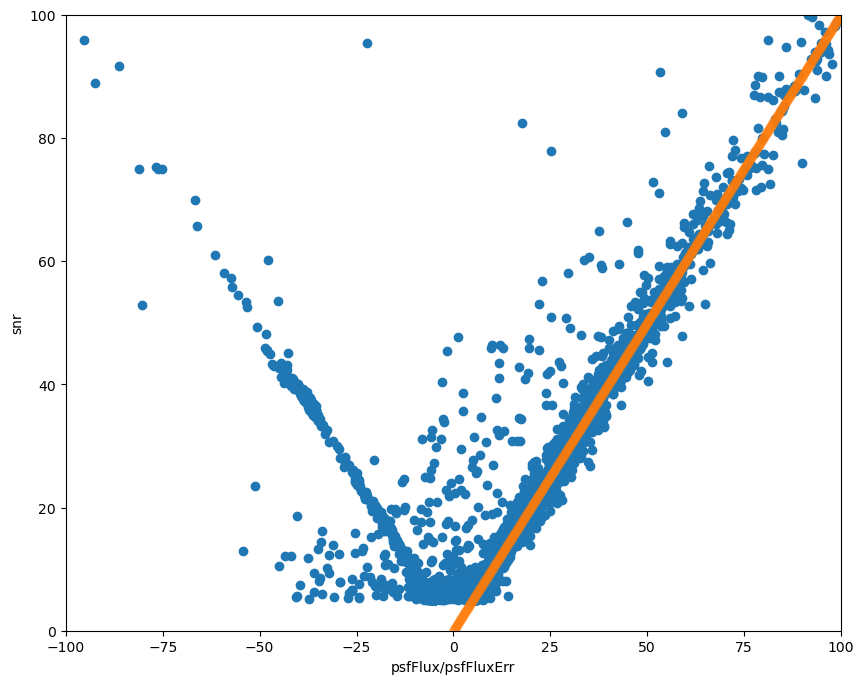

In [109]:
plt.figure(figsize=(10, 8))
plt.scatter(all_diaSource_df_not_dipole['psfFlux']/all_diaSource_df_not_dipole['psfFluxErr'] , all_diaSource_df_not_dipole['snr'], alpha=1);
plt.scatter(np.arange(0,2000,0.1), np.arange(0,2000,0.1), alpha=0.2)

plt.xlabel('psfFlux/psfFluxErr')
plt.ylabel('snr')
plt.xlim(-100,100)
plt.ylim(0,100)

In [122]:
all_diaSource_df_not_dipole[(psf_flux_ratio<-40)&(all_diaSource_df_not_dipole['snr']<20)][['visit','ra','dec', 'x','y','detector','band','diaSourceId','snr','psfFlux','psfFluxErr','shape_flag','pixelFlags_saturated','isDipole','pixelFlags_edge']]

,visit,ra,dec,x,y,detector,band,diaSourceId,snr,psfFlux,psfFluxErr,shape_flag,pixelFlags_saturated,isDipole,pixelFlags_edge
87,2024112600108,37.604748,6.500417,131.0,2591.0,6,r,191508653268795480,5.518884,-9347.456375,230.448327,True,False,False,False
18,2024112600110,38.166645,7.621728,2332.0,1395.0,2,r,191508655399501843,12.065872,-9160.122397,218.901260,True,False,False,False
34,2024112600112,37.695851,6.427145,2673.0,2182.0,6,g,191508657563762723,12.135193,-7334.049913,168.466407,True,False,False,False
50,2024112600114,37.961431,7.447999,1345.0,1081.0,5,g,191508659707052083,5.572882,-7600.165077,188.427725,True,False,False,False
46,2024112600115,37.783995,6.710252,914.0,1927.0,3,g,191508660772405296,18.680004,-7565.362664,187.673326,True,False,False,False
107,2024112600115,38.247067,6.290144,3473.0,3983.0,5,g,191508660780793964,10.520901,-7232.297050,161.081975,True,False,False,False
10,2024112600115,37.899403,6.425721,1136.0,962.0,7,g,191508660789182475,12.934480,-8864.618867,162.918278,True,False,False,False


In [126]:
all_diaSource_df_not_dipole[all_diaSource_df_not_dipole['band']=='u']

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
